# **Report**

**Autors**: Mykola Vysotskyi, Kohan Iryna

#### 0. Preparation for testing.

In this section we will prepare our data for testing. 
We just import all necessary libraries and generate graphs for testing.

You can skip this section.

In [2]:
import networkx as nx
from graph_generator import gnp_random_connected_graph

from timing import get_timing_data, plot_timing_data

Generate graphs for testing.

In [3]:
graphs = tuple(gnp_random_connected_graph(i, 0.1, draw=False) for i in range(10, 150, 10))

## 1. Graph algorithms.

### Task 1.1 Kruskal's and Prim's algorithms for minimum spanning tree.

Kruskal's and Prim's algorithms are a greedy algorithms that finds a minimum spanning tree for a connected weighted graph. This means it finds a subset of the edges that forms a tree that includes every vertex, where the total weight of all the edges in the tree is minimized. If the graph is not connected, then it finds a minimum spanning forest (a minimum spanning tree for each connected component).

Kruskal algorithm code.

In [4]:
def kruskal_search(graph: nx.Graph) -> nx.Graph:
    """
    Implements the Kruskal's algorithm to find
    the minimum spanning tree of a graph.
    Returns list[tuple], where tuple is tuple of nodes.

    Parameters
    ----------
    graph : nx.Graph
        Graph to find the minimum spanning tree of.
    
    Returns
    -------
    nx.Graph : Minimum spanning tree of the graph.
    """
    graph = graph.to_directed()
    edges = sorted(graph.edges(data=True), key = lambda x: x[2]['weight'])

    points = [{i} for i in list(graph.nodes())]
    result = nx.Graph()
    ind1, ind2 = None, None
    for edge in edges:
        for point in points:
            if edge[0] in point:
                ind1 = points.index(point)
            if edge[1] in point:
                ind2 = points.index(point)
        if ind1 != ind2:
            points[ind1] = points[ind1].union(points[ind2])
            del points[ind2]

            result.add_edge(edge[0], edge[1], weight=edge[2]['weight'])

    return result


Prim's algorithm code.

In [5]:
from queue import PriorityQueue

def prim_mst(graph: nx.Graph) -> nx.Graph:
    """
    Implements the Prim's algorithm to find
    the minimum spanning tree of a graph.
    Returns list[tuple], where tuple is tuple of nodes.

    Parameters
    ----------
    graph : nx.Graph
        Graph to find the minimum spanning tree of.
    
    Returns
    -------
    nx.Graph : Minimum spanning tree of the graph.
    """
    graph = graph.to_directed()
    visited = [False] * graph.number_of_nodes()
    visited[0] = True

    mst = nx.Graph()
    edges = PriorityQueue()

    for adj, data in graph.adj[0].items():
        if not visited[adj]:
            edges.put((data["weight"], 0, adj))

    while not edges.empty():
        weight, tree_vertex, vertex = edges.get()
        if visited[vertex]:
            continue
        mst.add_edge(tree_vertex, vertex, weight=weight)
        visited[vertex] = True

        for adj, data in graph.adj[vertex].items():
            if not visited[adj]:
                edges.put((data["weight"], vertex, adj))

    return mst

Let's test our algorithms on our generated graphs.

In [6]:
timing_data = get_timing_data(
{
    "Prim": (prim_mst, ()),
    "Kruskal": (kruskal_search, ()), 
    "Kruskal(networkx)": (nx.tree.maximum_spanning_tree, ()),
}, graphs)

c:\Users\Mykola\Desktop\dm-lab1\timing.py:82: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


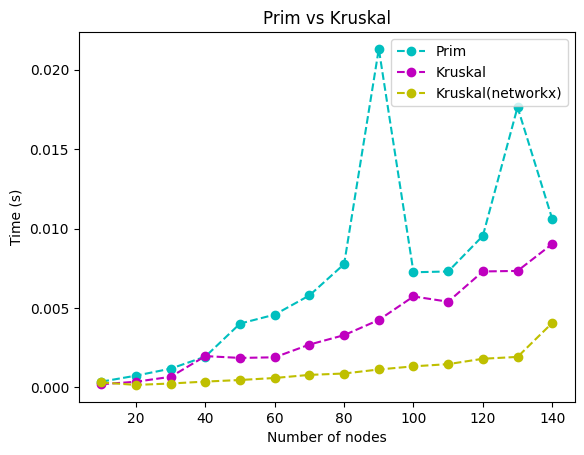

In [7]:
plot_timing_data(timing_data, title="Prim vs Kruskal", xlabel="Number of nodes", ylabel="Time (s)")

As we can see Kruskal's algorithm works faster than Prim's algorithm.
In Prim's algorithm implementation we use priority queue, but in Kruskal's algorithm we use sorting. So, we can say that sorting is faster than priority queue.

### Task 1.2 Bellman-Ford and Floyd-Warshall algorithms.

Bellman-Ford algorithm code.

In [4]:
def belman_ford_algorithm(graph: nx.Graph, start: int = 0) -> tuple[list[float], bool]:
    """
    Function implements Belman-Ford's algorithm.
    """
    graph = graph.to_directed()
    num_nodes = graph.number_of_nodes()
    edges = graph.edges(data="weight")

    distances = {idx: float("inf") for idx in range(num_nodes)}
    distances[start] = 0

    for _ in range(num_nodes - 1):
        for edge in edges:
            if distances[edge[1]] > (distances[edge[0]] + edge[2]):
                distances[edge[1]] = distances[edge[0]] + edge[2]

    for edge in edges:
        if distances[edge[1]] > ( distances[edge[0]] + edge[2]):
            return False

    return distances, True

In [13]:
# create wrapper for networkx.single_source_bellman_ford
# to deal with exceptions

def bf_nx(graph: nx.Graph) -> tuple[list[float], bool]:
    try:
        res = nx.single_source_bellman_ford(graph, 0)
    except nx.NetworkXUnbounded:
        return False
    
    return res, True

timing_data = get_timing_data(
{
    "Bellman-Ford": (belman_ford_algorithm, ()),
    "Bellman-Ford(networkx)": (bf_nx, ()),
}, graphs)

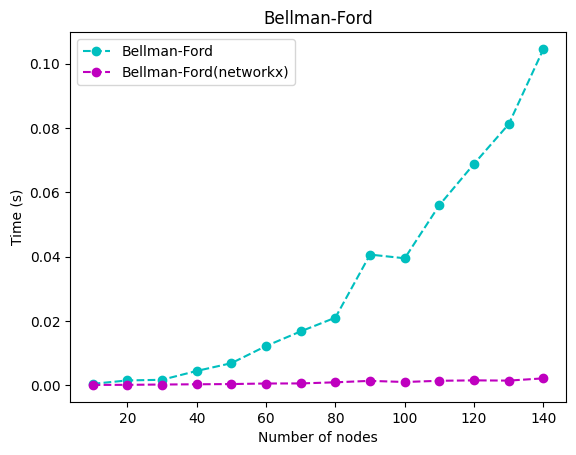

In [14]:
plot_timing_data(timing_data, title="Bellman-Ford", xlabel="Number of nodes", ylabel="Time (s)")

Floyd-Warshall algorithm code.

In [8]:
def have_negative_cycle(matrix: list[list[float]]) -> bool:
    """
    Function checks for negative cycle in matrix.
    """
    for idx, _ in enumerate(matrix):
        if matrix[idx][idx] < 0:
            return True

    return False

def floyd_warshall_algorithm(graph: nx.Graph) -> list[list[float]]:
    """
    Function implements Floyd-Warshall's algorithm.
    If there is a negative cycle in graph, function returns None.
    """
    graph = graph.to_directed()
    num_nodes = graph.number_of_nodes()
    edges = graph.edges(data="weight")

    matrix = [[float("inf") for _ in range(num_nodes)] for _ in range(num_nodes)]

    for idx in range(num_nodes):
        matrix[idx][idx] = 0

    for edge in edges:
        matrix[edge[0]][edge[1]] = edge[2]

    for k in range(num_nodes):
        for i in range(num_nodes):
            for j in range(num_nodes):
                if matrix[i][j] > matrix[i][k] + matrix[k][j]:
                    matrix[i][j] = matrix[i][k] + matrix[k][j]

    if have_negative_cycle(matrix):
        return None

    return matrix

In [9]:
timing_data = get_timing_data(
{
    "Floyd-Warshall": (floyd_warshall_algorithm, ()),
    "Floyd-Warshall(networkx)": (nx.floyd_warshall, ())
}, graphs)

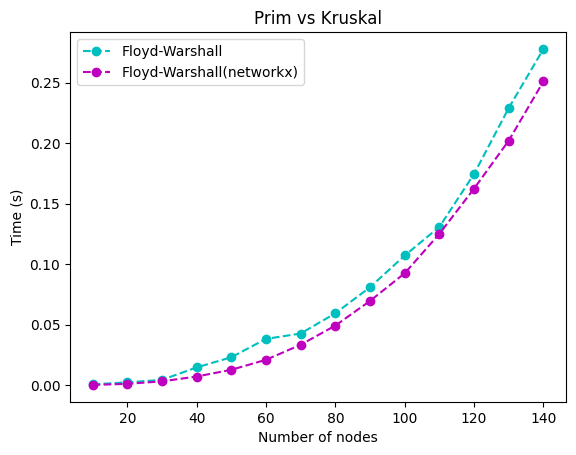

In [10]:
plot_timing_data(timing_data, title="Prim vs Kruskal", xlabel="Number of nodes", ylabel="Time (s)")

As we can see both algorithms work the same time.

## Task 2. Decision tree classifier.

This task is completed in the file [DecisionTreeClassiffier](DecisionTreeClassiffier.ipynb).
But also we implemented another decision tree algorithm called **ID3**. You can find it in the file [ID3](id3.ipynb).